In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, precision_score, accuracy_score, confusion_matrix

In [3]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [4]:
disease_types=['COVID', 'NON-COVID']
data_dir = '/content/drive/MyDrive/Github_edge_1/Pretwitt_1'
train_dir = os.path.join(data_dir)

In [5]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [6]:
train.head(6000)

,File,DiseaseID,Disease Type
0,COVID/img-2381.png,0,COVID
1,COVID/img-2382.png,0,COVID
2,COVID/img-2383.png,0,COVID
3,COVID/img-2384.png,0,COVID
4,COVID/img-2385.png,0,COVID
...,...,...,...
5995,NON-COVID/img-1005.png,1,NON-COVID
5996,NON-COVID/img-1006.png,1,NON-COVID
5997,NON-COVID/img-1007.png,1,NON-COVID
5998,NON-COVID/img-1008.png,1,NON-COVID


In [7]:
IMAGE_SIZE = 64
X = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values), total = len(train)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X /= 255.        
y = train['DiseaseID'].values
print(X.shape)
print(y.shape)


(6769, 64, 64, 3)
(6769,)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 1)

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))

model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(528, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0

In [11]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(x_train, y_train,
                    batch_size=64, epochs=100,steps_per_epoch=32,
                    verbose=1,validation_split=0.1)

Epoch 1/100
32/32 [==============================] - 1s 33ms/step - loss: 0.2511 - accuracy: 0.8994 - val_loss: 0.2278 - val_accuracy: 0.9280
Epoch 2/100
32/32 [==============================] - 1s 30ms/step - loss: 0.2471 - accuracy: 0.9004 - val_loss: 0.1924 - val_accuracy: 0.9280
Epoch 3/100
32/32 [==============================] - 1s 29ms/step - loss: 0.2427 - accuracy: 0.9047 - val_loss: 0.1803 - val_accuracy: 0.9336
Epoch 4/100
32/32 [==============================] - 1s 32ms/step - loss: 0.2065 - accuracy: 0.9175 - val_loss: 0.1670 - val_accuracy: 0.9354
Epoch 5/100
32/32 [==============================] - 1s 29ms/step - loss: 0.2347 - accuracy: 0.9072 - val_loss: 0.1953 - val_accuracy: 0.9244
Epoch 6/100
32/32 [==============================] - 1s 30ms/step - loss: 0.1987 - accuracy: 0.9204 - val_loss: 0.2298 - val_accuracy: 0.9022
Epoch 7/100
32/32 [==============================] - 1s 30ms/step - loss: 0.1622 - accuracy: 0.9399 - val_loss: 0.1640 - val_accuracy: 0.9410
Epoch 

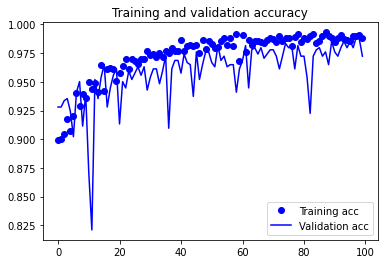

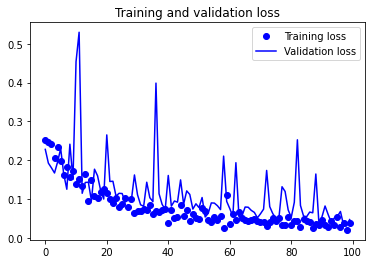

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [15]:
y_pred = model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [16]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [17]:
sp = tn/(tn+fp)
sn = tp/(tp+fn)

print('f1 score =  %.3f'%f1_score(y_test, y_pred))
print('Precision =  %.3f'%precision_score(y_test, y_pred))
print('Test accuracy =  %.3f'%accuracy_score(y_test, y_pred))
print('Specificity =  %.3f'%sp)
print('Sensitivity =  %.3f'%sn)

f1 score =  0.971
Precision =  0.979
Test accuracy =  0.971
Specificity =  0.979
Sensitivity =  0.963
